<a href="https://colab.research.google.com/github/miya498/pytorch_basic/blob/main/program/th07_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8章　MNISTを使った数字認識

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

## 8.3 ReLU関数

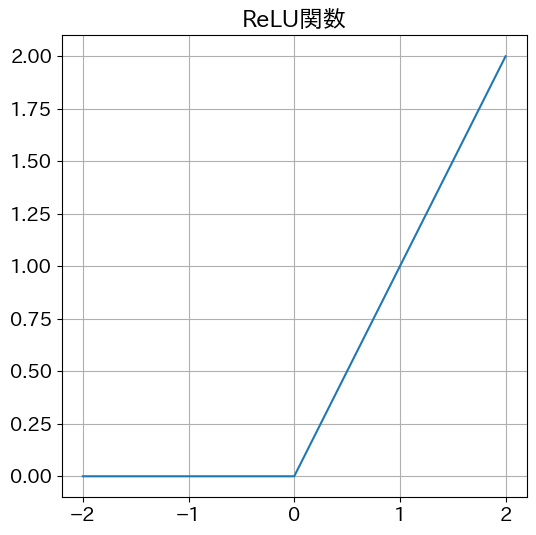

In [2]:
# ReLU関数のグラフ

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

## 8.4 GPU利用

In [3]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 8.8 データ準備1 (データセットによる読み込み)

In [4]:
# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,
    # 訓練データか検証データか
    train = True,
    # 元データがない場合にダウンロードするか
    download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 130474537.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 80275476.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52150537.63it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1014189.14it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# ダウンロードしたファイルの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Apr  3 06:51 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Apr  3 06:51 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Apr  3 06:51 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Apr  3 06:51 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Apr  3 06:51 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Apr  3 06:51 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Apr  3 06:51 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Apr  3 06:51 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Apr  3 06:51 train-labels-idx1-ubyte.gz


In [6]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解データの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解データの型:  <class 'int'>


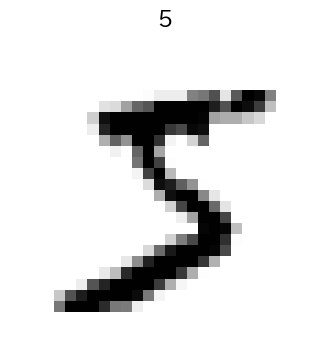

In [7]:
# 入力データの画像表示

plt.figure(figsize=(4,5))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

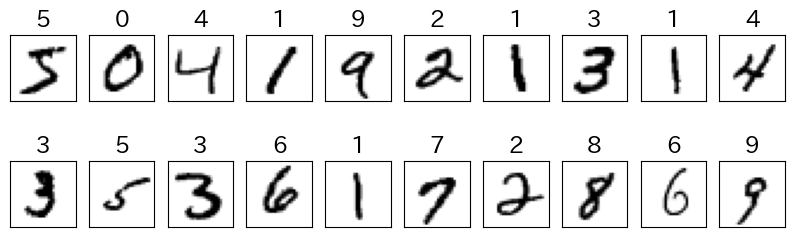

In [8]:
# 正解データ付きで、最初の20個をイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # image と labelの取得
    image, label = train_set0[i]

    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.9 データ準備2 (Transformsによるデータ前処理)

### Step1 ToTensorの利用

In [9]:
# ライブラリインポート
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root,  train=True,  download=True,
    transform = transform1)

In [10]:
# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


### Step2 Normalizeの利用

In [11]:
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),

    # データの正規化
    transforms.Normalize(0.5,  0.5),
])

train_set2 = datasets.MNIST(
    root = data_root,  train = True,  download = True,
    transform = transform2)

In [12]:
# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)



### Step3 Lambdaを利用して1階テンソル化

In [13]:
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),

    # データの正規化
    transforms.Normalize(0.5, 0.5),

    # Tensorの1階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,  train = True,
    download=True, transform = transform3)

In [14]:
# 変換結果の確認

image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


### 最終的な実装

In [15]:
# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),

    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),

    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [16]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform)

## 8.10 データ準備3 データローダーによるミニバッチ用データ生成)

バッチサイズは小さくすることで精度が向上する

In [17]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  batch_size = batch_size,
    shuffle = False)

In [18]:
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


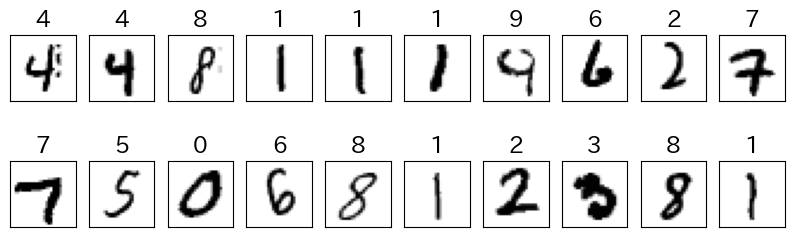

In [19]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # numpyに変換
    image = images[i].numpy()
    label = labels[i]

    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.11 モデル定義

In [20]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels.data.numpy())))

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [21]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [22]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

### 最適化アルゴリズムと損失関数

In [23]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

### モデル確認

In [24]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [25]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [26]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## 8.12 勾配降下法

### 予測計算

In [27]:
# 訓練データセット　最初の1項目を取得
# データローダーから最初の1セットを取得する
for images, labels in train_loader:
    break

In [28]:
# データローダーから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [29]:
# 予測計算
outputs = net(inputs)

# 結果確認
print(outputs)

tensor([[-0.3622, -0.1927, -0.0179,  ...,  0.1073,  0.1025, -0.0615],
        [-0.4072, -0.1814,  0.0716,  ...,  0.1866,  0.1975,  0.1161],
        [-0.3221, -0.0547, -0.2868,  ...,  0.1967, -0.0103,  0.1591],
        ...,
        [-0.2091, -0.1058,  0.2365,  ...,  0.1360,  0.0665,  0.0987],
        [-0.2756, -0.2012,  0.1703,  ...,  0.1223,  0.2388,  0.0233],
        [-0.3045, -0.2458,  0.1416,  ...,  0.1012,  0.0820, -0.1457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


### 損失関数

#### 損失計算と計算グラフの可視化

2.3328874111175537


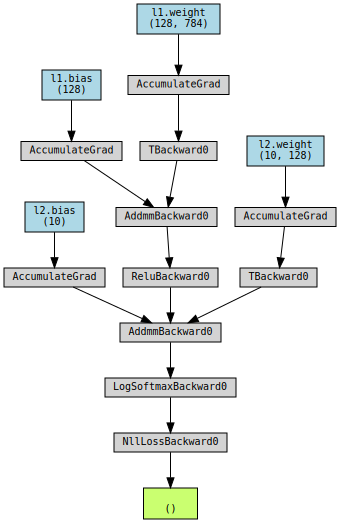

In [30]:
#  損失計算
loss = criterion(outputs, labels)

# 損失値の取得
print(loss.item())

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 勾配計算

In [31]:
# 勾配計算の実行
loss.backward()

# 勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.00071 -0.00071 -0.00071 ... -0.00071 -0.00071 -0.00071]
 [ 0.00768  0.00768  0.00768 ...  0.00768  0.00768  0.00768]
 [-0.00179 -0.00179 -0.00179 ... -0.00179 -0.00179 -0.00179]
 ...
 [-0.00076 -0.00076 -0.00076 ... -0.00076 -0.00076 -0.00076]
 [ 0.0011   0.0011   0.0011  ...  0.0011   0.0011   0.0011 ]
 [-0.00009 -0.00009 -0.00009 ... -0.00009 -0.00009 -0.00009]]
[ 0.00071 -0.00768  0.00179  0.00085 -0.00004  0.00004  0.00135 -0.00085
  0.00254 -0.00164  0.00086 -0.00196  0.00059  0.00252 -0.00256  0.00075
  0.00605 -0.00109 -0.00177  0.00799  0.00627  0.00256 -0.00358  0.00563
 -0.00059 -0.00379  0.00343  0.      -0.00257 -0.00319 -0.00055  0.00345
  0.00175  0.00001  0.00007  0.00024  0.0047  -0.00124  0.00215  0.00183
  0.00371 -0.00607  0.00109  0.00972 -0.0017  -0.00124 -0.00044 -0.00102
 -0.00306 -0.00029 -0.0008   0.00041  0.00009 -0.00159 -0.00205 -0.00007
 -0.00059 -0.00235 -0.00043  0.00292  0.00128 -0.00846  0.0013   0.00154
  0.      -0.00055  0.00403 -0.00165 -0.0052

### パラメータ修正

In [32]:
# 勾配降下法の適用
optimizer.step()

# パラメータ値の表示
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0278,  0.0200,  0.0316],
        [ 0.0183, -0.0322,  0.0174,  ...,  0.0088, -0.0029, -0.0034],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0323, -0.0059, -0.0169],
        [-0.0329, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2475e-02, -2.9682e-02,  1.2742e-03,  1.9874e-02,  2.6836e-02,
        -2.4759e-02, -1.7201e-02, -3.5517e-02,  1.2199e-02, -4.7449e-03,
         2.1379e-02,  2.0187e-02, -2.4297e-02,  1.4928e-03, -2.7613e-02,
         2.9618e-02,  3.4051e-02, -2.2777e-02,  2.2983e-02,  3.4580e-02,
        -9.1870e-03, -3.4619e-02,  2.0599e-02, -6.0632e-03,  3.2937e-02,
         4.7784e-03,  1.7949e-02,  1.0102e-02,  1.7700e-02, -3.0853e-02,
         2.2817e-02, -2.2391e-02,  3.2049e-02,  1.7890e-0

### 繰り返し計算

In [33]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [34]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)

        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()

        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)


        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56958 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03888 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87878 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37876 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.34868, val_acc: 0.90160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35910 acc: 0.89783 val_loss: 0.34089, val_acc: 0.90220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336, val_acc: 0.90490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34477 acc: 0.90135 val_loss: 0.32806, val_acc: 0.90570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90310 val_loss: 0.32334, val_acc: 0.90710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.31807, val_acc: 0.90790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.31445, val_acc: 0.90930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90700 val_loss: 0.31076, val_acc: 0.91090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90807 val_loss: 0.30586, val_acc: 0.91190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90905 val_loss: 0.30281, val_acc: 0.91240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91032 val_loss: 0.29965, val_acc: 0.91520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91098 val_loss: 0.29713, val_acc: 0.91430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91195 val_loss: 0.29432, val_acc: 0.91570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30190 acc: 0.91320 val_loss: 0.29123, val_acc: 0.91770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91403 val_loss: 0.28884, val_acc: 0.91700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91492 val_loss: 0.28646, val_acc: 0.91820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91662 val_loss: 0.28365, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91698 val_loss: 0.28185, val_acc: 0.92000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28765 acc: 0.91798 val_loss: 0.28041, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28510 acc: 0.91858 val_loss: 0.27748, val_acc: 0.92110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28233 acc: 0.91958 val_loss: 0.27485, val_acc: 0.92180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27989 acc: 0.92040 val_loss: 0.27255, val_acc: 0.92120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27763 acc: 0.92067 val_loss: 0.27010, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27513 acc: 0.92102 val_loss: 0.26897, val_acc: 0.92410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27278 acc: 0.92242 val_loss: 0.26668, val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27048 acc: 0.92280 val_loss: 0.26462, val_acc: 0.92360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26828 acc: 0.92358 val_loss: 0.26279, val_acc: 0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26597 acc: 0.92403 val_loss: 0.26075, val_acc: 0.92550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26357 acc: 0.92455 val_loss: 0.25918, val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26157 acc: 0.92565 val_loss: 0.25719, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25919 acc: 0.92603 val_loss: 0.25558, val_acc: 0.92630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25715 acc: 0.92695 val_loss: 0.25282, val_acc: 0.92720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25496 acc: 0.92765 val_loss: 0.25100, val_acc: 0.92940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25292 acc: 0.92775 val_loss: 0.24995, val_acc: 0.92800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25096 acc: 0.92845 val_loss: 0.24743, val_acc: 0.92930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24867 acc: 0.92937 val_loss: 0.24636, val_acc: 0.93070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24664 acc: 0.92965 val_loss: 0.24402, val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24463 acc: 0.93042 val_loss: 0.24264, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24266 acc: 0.93060 val_loss: 0.24012, val_acc: 0.93220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24070 acc: 0.93147 val_loss: 0.23928, val_acc: 0.93250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23872 acc: 0.93212 val_loss: 0.23708, val_acc: 0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23680 acc: 0.93225 val_loss: 0.23567, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23485 acc: 0.93345 val_loss: 0.23360, val_acc: 0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23294 acc: 0.93442 val_loss: 0.23177, val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23101 acc: 0.93478 val_loss: 0.22988, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22909 acc: 0.93517 val_loss: 0.22863, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22729 acc: 0.93568 val_loss: 0.22641, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22537 acc: 0.93643 val_loss: 0.22547, val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22367 acc: 0.93693 val_loss: 0.22324, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22190 acc: 0.93743 val_loss: 0.22190, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22019 acc: 0.93808 val_loss: 0.22011, val_acc: 0.93690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21845 acc: 0.93840 val_loss: 0.21884, val_acc: 0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21653 acc: 0.93903 val_loss: 0.21656, val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21485 acc: 0.93970 val_loss: 0.21577, val_acc: 0.93910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21321 acc: 0.94003 val_loss: 0.21334, val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21152 acc: 0.94050 val_loss: 0.21216, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20996 acc: 0.94112 val_loss: 0.21143, val_acc: 0.93960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20826 acc: 0.94157 val_loss: 0.20924, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20673 acc: 0.94210 val_loss: 0.20716, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20500 acc: 0.94235 val_loss: 0.20682, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20353 acc: 0.94292 val_loss: 0.20485, val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20198 acc: 0.94355 val_loss: 0.20380, val_acc: 0.94120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20053 acc: 0.94373 val_loss: 0.20211, val_acc: 0.94110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19892 acc: 0.94420 val_loss: 0.20087, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19754 acc: 0.94453 val_loss: 0.19895, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19587 acc: 0.94513 val_loss: 0.19793, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19454 acc: 0.94533 val_loss: 0.19671, val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19313 acc: 0.94565 val_loss: 0.19520, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19163 acc: 0.94620 val_loss: 0.19405, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19041 acc: 0.94635 val_loss: 0.19304, val_acc: 0.94360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18891 acc: 0.94713 val_loss: 0.19190, val_acc: 0.94340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18764 acc: 0.94737 val_loss: 0.19039, val_acc: 0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18620 acc: 0.94795 val_loss: 0.18892, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18487 acc: 0.94812 val_loss: 0.18786, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18358 acc: 0.94818 val_loss: 0.18690, val_acc: 0.94610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18228 acc: 0.94888 val_loss: 0.18556, val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18101 acc: 0.94955 val_loss: 0.18461, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17976 acc: 0.94977 val_loss: 0.18364, val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17846 acc: 0.95025 val_loss: 0.18184, val_acc: 0.94720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17737 acc: 0.95042 val_loss: 0.18089, val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17612 acc: 0.95097 val_loss: 0.17952, val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17488 acc: 0.95118 val_loss: 0.17919, val_acc: 0.94800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17383 acc: 0.95140 val_loss: 0.17744, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17264 acc: 0.95175 val_loss: 0.17635, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17143 acc: 0.95218 val_loss: 0.17556, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17035 acc: 0.95275 val_loss: 0.17470, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16915 acc: 0.95272 val_loss: 0.17389, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16811 acc: 0.95332 val_loss: 0.17414, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16696 acc: 0.95357 val_loss: 0.17145, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16583 acc: 0.95408 val_loss: 0.17067, val_acc: 0.94960


## 8.13 結果確認

In [35]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.32629 精度: 0.74660
最終状態: 損失: 0.17067 精度: 0.94960


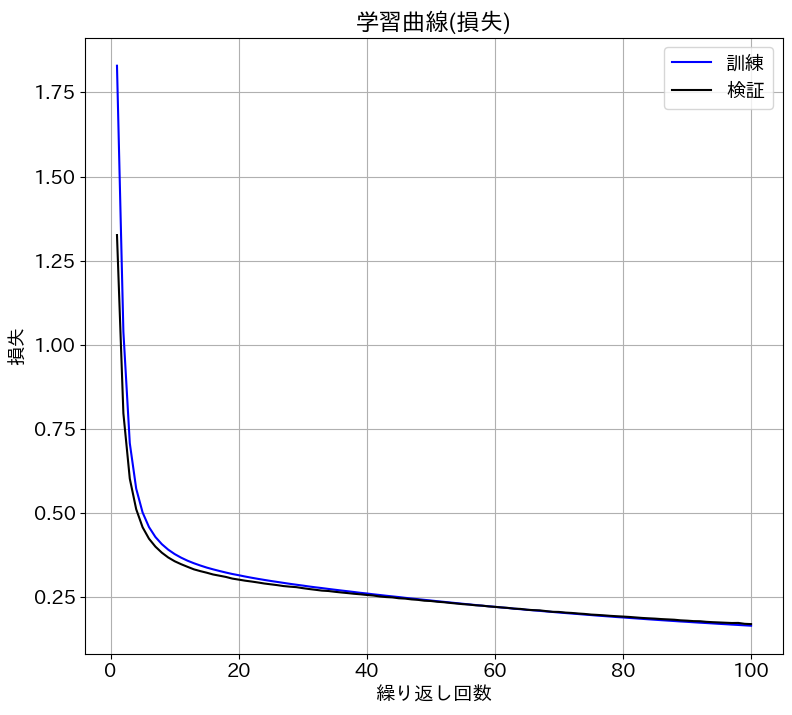

In [36]:
# 学習曲線の表示 (損失)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

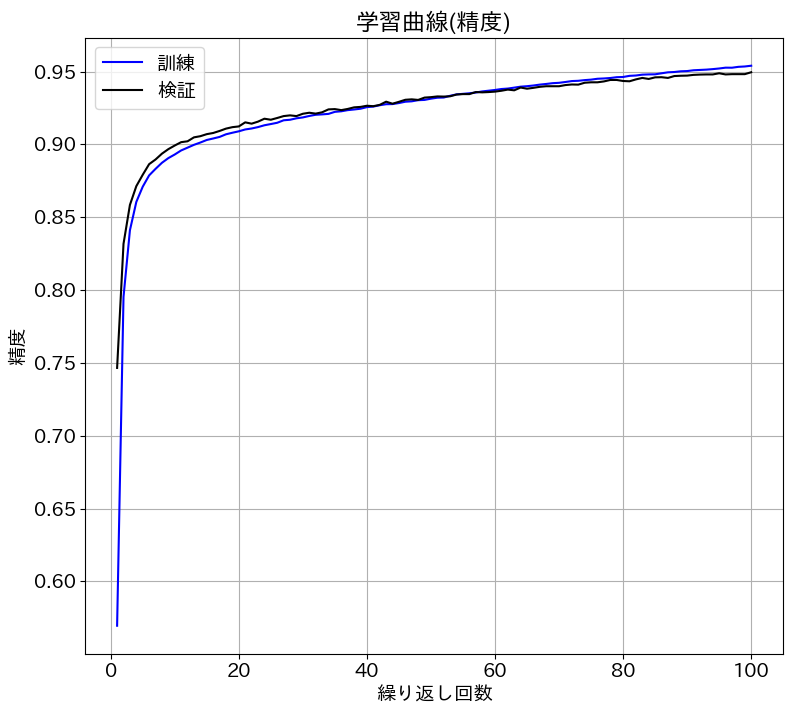

In [37]:
# 学習曲線の表示 (精度)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### イメージ表示で確認

In [38]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

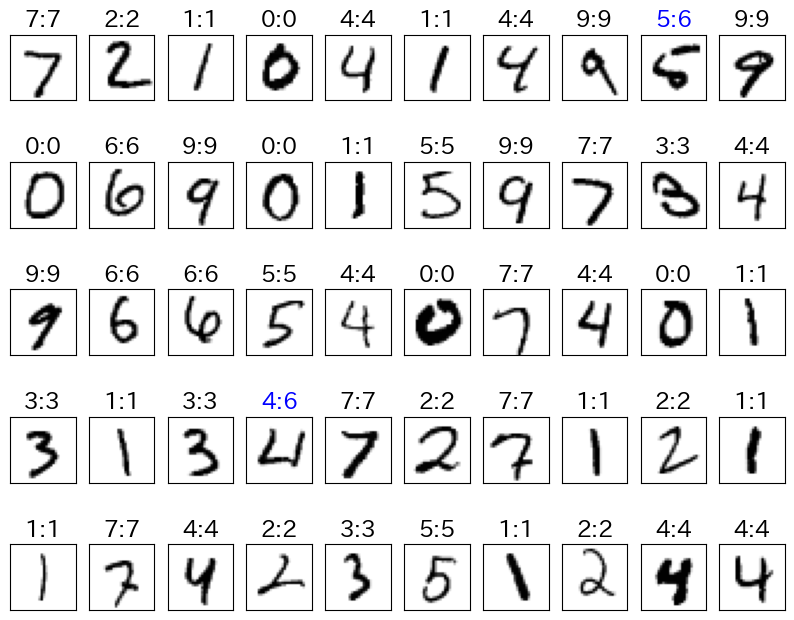

In [39]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)

  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'

  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2

  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## 8.14 隠れ層の2層化

In [40]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [41]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [42]:
# モデルの概要表示

print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [43]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [128]                     16,512
├─ReLU: 1-4                              [128]                     --
├─Linear: 1-5                            [10]                      1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 14.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.48

In [44]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)

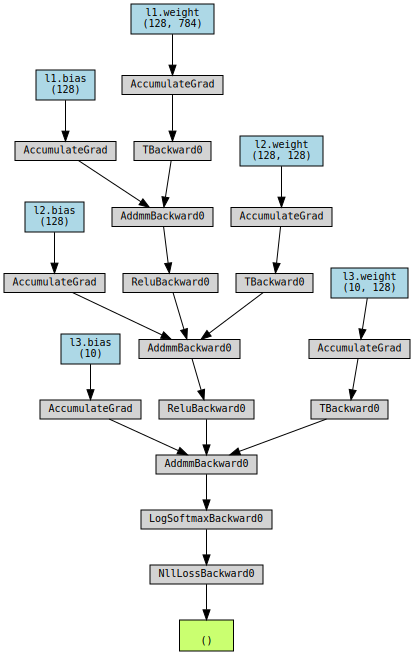

In [45]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
make_dot(loss, params=dict(net.named_parameters()))

In [46]:
# 勾配計算
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 各要素の絶対値の平均
print(np.abs(w).mean())

[[-0.00071 -0.00071 -0.00071 ... -0.00071 -0.00071 -0.00071]
 [-0.0001  -0.0001  -0.0001  ... -0.0001  -0.0001  -0.0001 ]
 [-0.00053 -0.00053 -0.00053 ... -0.00053 -0.00053 -0.00053]
 ...
 [ 0.00148  0.00148  0.00148 ...  0.00148  0.00148  0.00148]
 [ 0.00023  0.00023  0.00023 ...  0.00023  0.00023  0.00023]
 [ 0.00028  0.00028  0.00028 ...  0.00028  0.00028  0.00028]]
0.0008487979


### 繰り返し計算

In [47]:
# 乱数の固定化
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history2 = np.zeros((0,5))

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)

        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()

        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/200], loss: 2.20163 acc: 0.25380 val_loss: 2.04576, val_acc: 0.49800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/200], loss: 1.75820 acc: 0.60443 val_loss: 1.39272, val_acc: 0.68680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/200], loss: 1.11284 acc: 0.75645 val_loss: 0.86510, val_acc: 0.80810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/200], loss: 0.75170 acc: 0.82300 val_loss: 0.63477, val_acc: 0.84380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/200], loss: 0.59030 acc: 0.84983 val_loss: 0.52462, val_acc: 0.86370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/200], loss: 0.50672 acc: 0.86653 val_loss: 0.46400, val_acc: 0.87440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/200], loss: 0.45680 acc: 0.87540 val_loss: 0.42148, val_acc: 0.88560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/200], loss: 0.42335 acc: 0.88195 val_loss: 0.39551, val_acc: 0.89020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/200], loss: 0.39965 acc: 0.88768 val_loss: 0.37600, val_acc: 0.89350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/200], loss: 0.38195 acc: 0.89183 val_loss: 0.35886, val_acc: 0.89880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/200], loss: 0.36793 acc: 0.89477 val_loss: 0.34926, val_acc: 0.90350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/200], loss: 0.35633 acc: 0.89803 val_loss: 0.33760, val_acc: 0.90400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/200], loss: 0.34648 acc: 0.89965 val_loss: 0.32775, val_acc: 0.90580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/200], loss: 0.33814 acc: 0.90202 val_loss: 0.32063, val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/200], loss: 0.33042 acc: 0.90457 val_loss: 0.31807, val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/200], loss: 0.32382 acc: 0.90603 val_loss: 0.31015, val_acc: 0.91130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/200], loss: 0.31778 acc: 0.90760 val_loss: 0.30470, val_acc: 0.91140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/200], loss: 0.31207 acc: 0.90910 val_loss: 0.30015, val_acc: 0.91420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/200], loss: 0.30685 acc: 0.91078 val_loss: 0.29439, val_acc: 0.91420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/200], loss: 0.30213 acc: 0.91208 val_loss: 0.29150, val_acc: 0.91500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/200], loss: 0.29752 acc: 0.91375 val_loss: 0.28592, val_acc: 0.91640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/200], loss: 0.29328 acc: 0.91498 val_loss: 0.28179, val_acc: 0.91750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/200], loss: 0.28877 acc: 0.91608 val_loss: 0.27957, val_acc: 0.91850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/200], loss: 0.28525 acc: 0.91685 val_loss: 0.27463, val_acc: 0.92080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/200], loss: 0.28129 acc: 0.91833 val_loss: 0.27169, val_acc: 0.92160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/200], loss: 0.27772 acc: 0.91927 val_loss: 0.26890, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/200], loss: 0.27411 acc: 0.92007 val_loss: 0.26614, val_acc: 0.92380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/200], loss: 0.27080 acc: 0.92125 val_loss: 0.26244, val_acc: 0.92470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/200], loss: 0.26760 acc: 0.92232 val_loss: 0.26265, val_acc: 0.92320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/200], loss: 0.26484 acc: 0.92292 val_loss: 0.25895, val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/200], loss: 0.26135 acc: 0.92375 val_loss: 0.25497, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/200], loss: 0.25843 acc: 0.92477 val_loss: 0.25228, val_acc: 0.92730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/200], loss: 0.25552 acc: 0.92570 val_loss: 0.25114, val_acc: 0.92570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/200], loss: 0.25280 acc: 0.92637 val_loss: 0.24734, val_acc: 0.92770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/200], loss: 0.24960 acc: 0.92760 val_loss: 0.24460, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/200], loss: 0.24677 acc: 0.92835 val_loss: 0.24469, val_acc: 0.92770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/200], loss: 0.24411 acc: 0.92962 val_loss: 0.24130, val_acc: 0.92830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/200], loss: 0.24158 acc: 0.93008 val_loss: 0.23741, val_acc: 0.93190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/200], loss: 0.23886 acc: 0.93110 val_loss: 0.23472, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/200], loss: 0.23617 acc: 0.93165 val_loss: 0.23369, val_acc: 0.93230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/200], loss: 0.23374 acc: 0.93222 val_loss: 0.22987, val_acc: 0.93330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/200], loss: 0.23095 acc: 0.93275 val_loss: 0.22863, val_acc: 0.93270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/200], loss: 0.22849 acc: 0.93407 val_loss: 0.22667, val_acc: 0.93570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/200], loss: 0.22612 acc: 0.93477 val_loss: 0.22332, val_acc: 0.93500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/200], loss: 0.22344 acc: 0.93500 val_loss: 0.22107, val_acc: 0.93450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/200], loss: 0.22103 acc: 0.93582 val_loss: 0.21979, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/200], loss: 0.21872 acc: 0.93680 val_loss: 0.21706, val_acc: 0.93650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/200], loss: 0.21632 acc: 0.93757 val_loss: 0.21633, val_acc: 0.93740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/200], loss: 0.21397 acc: 0.93832 val_loss: 0.21385, val_acc: 0.93840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/200], loss: 0.21180 acc: 0.93890 val_loss: 0.21025, val_acc: 0.93730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/200], loss: 0.20944 acc: 0.93947 val_loss: 0.20930, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/200], loss: 0.20723 acc: 0.94013 val_loss: 0.20952, val_acc: 0.93590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/200], loss: 0.20505 acc: 0.94080 val_loss: 0.20475, val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/200], loss: 0.20265 acc: 0.94133 val_loss: 0.20285, val_acc: 0.93920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/200], loss: 0.20043 acc: 0.94240 val_loss: 0.20079, val_acc: 0.94180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/200], loss: 0.19844 acc: 0.94278 val_loss: 0.19841, val_acc: 0.94190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/200], loss: 0.19652 acc: 0.94387 val_loss: 0.19672, val_acc: 0.94180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/200], loss: 0.19422 acc: 0.94392 val_loss: 0.19496, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/200], loss: 0.19227 acc: 0.94440 val_loss: 0.19377, val_acc: 0.94300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/200], loss: 0.19031 acc: 0.94528 val_loss: 0.19109, val_acc: 0.94320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/200], loss: 0.18842 acc: 0.94557 val_loss: 0.18999, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/200], loss: 0.18623 acc: 0.94682 val_loss: 0.18821, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/200], loss: 0.18460 acc: 0.94673 val_loss: 0.18559, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/200], loss: 0.18266 acc: 0.94707 val_loss: 0.18447, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/200], loss: 0.18072 acc: 0.94807 val_loss: 0.18251, val_acc: 0.94560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/200], loss: 0.17906 acc: 0.94835 val_loss: 0.18064, val_acc: 0.94540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/200], loss: 0.17725 acc: 0.94930 val_loss: 0.17930, val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/200], loss: 0.17531 acc: 0.94973 val_loss: 0.17716, val_acc: 0.94670


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/200], loss: 0.17379 acc: 0.94982 val_loss: 0.17560, val_acc: 0.94860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/200], loss: 0.17195 acc: 0.95057 val_loss: 0.17435, val_acc: 0.94790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/200], loss: 0.17031 acc: 0.95115 val_loss: 0.17268, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/200], loss: 0.16849 acc: 0.95137 val_loss: 0.17090, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/200], loss: 0.16690 acc: 0.95195 val_loss: 0.17039, val_acc: 0.94960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/200], loss: 0.16519 acc: 0.95257 val_loss: 0.16927, val_acc: 0.95040


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/200], loss: 0.16374 acc: 0.95277 val_loss: 0.16797, val_acc: 0.94950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/200], loss: 0.16229 acc: 0.95353 val_loss: 0.16560, val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/200], loss: 0.16060 acc: 0.95375 val_loss: 0.16512, val_acc: 0.95150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/200], loss: 0.15917 acc: 0.95432 val_loss: 0.16286, val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/200], loss: 0.15768 acc: 0.95463 val_loss: 0.16262, val_acc: 0.95160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/200], loss: 0.15609 acc: 0.95530 val_loss: 0.16006, val_acc: 0.95310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/200], loss: 0.15466 acc: 0.95563 val_loss: 0.15933, val_acc: 0.95280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/200], loss: 0.15333 acc: 0.95590 val_loss: 0.15824, val_acc: 0.95270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/200], loss: 0.15187 acc: 0.95628 val_loss: 0.15676, val_acc: 0.95300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/200], loss: 0.15063 acc: 0.95693 val_loss: 0.15557, val_acc: 0.95400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/200], loss: 0.14918 acc: 0.95718 val_loss: 0.15529, val_acc: 0.95400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/200], loss: 0.14785 acc: 0.95778 val_loss: 0.15300, val_acc: 0.95410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/200], loss: 0.14652 acc: 0.95782 val_loss: 0.15197, val_acc: 0.95440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/200], loss: 0.14521 acc: 0.95833 val_loss: 0.15013, val_acc: 0.95480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/200], loss: 0.14407 acc: 0.95883 val_loss: 0.14955, val_acc: 0.95500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/200], loss: 0.14251 acc: 0.95927 val_loss: 0.14936, val_acc: 0.95510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/200], loss: 0.14150 acc: 0.95972 val_loss: 0.14767, val_acc: 0.95540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/200], loss: 0.14013 acc: 0.95967 val_loss: 0.14766, val_acc: 0.95580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/200], loss: 0.13901 acc: 0.96018 val_loss: 0.14749, val_acc: 0.95610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/200], loss: 0.13766 acc: 0.96070 val_loss: 0.14508, val_acc: 0.95630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/200], loss: 0.13663 acc: 0.96098 val_loss: 0.14403, val_acc: 0.95620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/200], loss: 0.13549 acc: 0.96135 val_loss: 0.14406, val_acc: 0.95680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/200], loss: 0.13421 acc: 0.96170 val_loss: 0.14099, val_acc: 0.95690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/200], loss: 0.13313 acc: 0.96215 val_loss: 0.14105, val_acc: 0.95710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/200], loss: 0.13193 acc: 0.96240 val_loss: 0.13979, val_acc: 0.95710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/200], loss: 0.13093 acc: 0.96290 val_loss: 0.13874, val_acc: 0.95820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [101/200], loss: 0.12983 acc: 0.96282 val_loss: 0.13778, val_acc: 0.95850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [102/200], loss: 0.12867 acc: 0.96338 val_loss: 0.13749, val_acc: 0.95800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [103/200], loss: 0.12770 acc: 0.96382 val_loss: 0.13569, val_acc: 0.95870


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [104/200], loss: 0.12657 acc: 0.96403 val_loss: 0.13551, val_acc: 0.95830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [105/200], loss: 0.12555 acc: 0.96413 val_loss: 0.13537, val_acc: 0.95950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [106/200], loss: 0.12454 acc: 0.96450 val_loss: 0.13384, val_acc: 0.95880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [107/200], loss: 0.12355 acc: 0.96500 val_loss: 0.13300, val_acc: 0.95940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [108/200], loss: 0.12245 acc: 0.96545 val_loss: 0.13181, val_acc: 0.95940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [109/200], loss: 0.12138 acc: 0.96570 val_loss: 0.13180, val_acc: 0.95880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [110/200], loss: 0.12066 acc: 0.96583 val_loss: 0.13066, val_acc: 0.95960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [111/200], loss: 0.11939 acc: 0.96618 val_loss: 0.12961, val_acc: 0.96050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [112/200], loss: 0.11858 acc: 0.96645 val_loss: 0.12890, val_acc: 0.96080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [113/200], loss: 0.11760 acc: 0.96635 val_loss: 0.12777, val_acc: 0.96080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [114/200], loss: 0.11658 acc: 0.96673 val_loss: 0.12743, val_acc: 0.96050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [115/200], loss: 0.11588 acc: 0.96735 val_loss: 0.12675, val_acc: 0.96090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [116/200], loss: 0.11488 acc: 0.96715 val_loss: 0.12588, val_acc: 0.96100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [117/200], loss: 0.11386 acc: 0.96783 val_loss: 0.12518, val_acc: 0.96180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [118/200], loss: 0.11304 acc: 0.96753 val_loss: 0.12503, val_acc: 0.96180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [119/200], loss: 0.11223 acc: 0.96837 val_loss: 0.12356, val_acc: 0.96190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [120/200], loss: 0.11142 acc: 0.96842 val_loss: 0.12330, val_acc: 0.96190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [121/200], loss: 0.11045 acc: 0.96858 val_loss: 0.12316, val_acc: 0.96290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [122/200], loss: 0.10967 acc: 0.96897 val_loss: 0.12150, val_acc: 0.96300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [123/200], loss: 0.10868 acc: 0.96920 val_loss: 0.12167, val_acc: 0.96250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [124/200], loss: 0.10768 acc: 0.96982 val_loss: 0.12060, val_acc: 0.96280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [125/200], loss: 0.10709 acc: 0.96978 val_loss: 0.11974, val_acc: 0.96270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [126/200], loss: 0.10629 acc: 0.96997 val_loss: 0.11997, val_acc: 0.96220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [127/200], loss: 0.10540 acc: 0.97012 val_loss: 0.11889, val_acc: 0.96320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [128/200], loss: 0.10460 acc: 0.97058 val_loss: 0.11816, val_acc: 0.96430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [129/200], loss: 0.10395 acc: 0.97047 val_loss: 0.11782, val_acc: 0.96360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [130/200], loss: 0.10302 acc: 0.97108 val_loss: 0.11684, val_acc: 0.96390


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [131/200], loss: 0.10223 acc: 0.97088 val_loss: 0.11625, val_acc: 0.96430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [132/200], loss: 0.10163 acc: 0.97120 val_loss: 0.11759, val_acc: 0.96340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [133/200], loss: 0.10088 acc: 0.97155 val_loss: 0.11628, val_acc: 0.96440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [134/200], loss: 0.10008 acc: 0.97188 val_loss: 0.11574, val_acc: 0.96460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [135/200], loss: 0.09924 acc: 0.97220 val_loss: 0.11441, val_acc: 0.96420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [136/200], loss: 0.09864 acc: 0.97222 val_loss: 0.11458, val_acc: 0.96490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [137/200], loss: 0.09801 acc: 0.97248 val_loss: 0.11278, val_acc: 0.96540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [138/200], loss: 0.09724 acc: 0.97282 val_loss: 0.11282, val_acc: 0.96540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [139/200], loss: 0.09646 acc: 0.97285 val_loss: 0.11305, val_acc: 0.96420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [140/200], loss: 0.09577 acc: 0.97328 val_loss: 0.11181, val_acc: 0.96520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [141/200], loss: 0.09504 acc: 0.97352 val_loss: 0.11155, val_acc: 0.96570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [142/200], loss: 0.09446 acc: 0.97365 val_loss: 0.11027, val_acc: 0.96710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [143/200], loss: 0.09382 acc: 0.97373 val_loss: 0.11010, val_acc: 0.96580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [144/200], loss: 0.09307 acc: 0.97363 val_loss: 0.10959, val_acc: 0.96700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [145/200], loss: 0.09245 acc: 0.97435 val_loss: 0.11006, val_acc: 0.96590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [146/200], loss: 0.09182 acc: 0.97428 val_loss: 0.10807, val_acc: 0.96740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [147/200], loss: 0.09105 acc: 0.97463 val_loss: 0.10816, val_acc: 0.96700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [148/200], loss: 0.09048 acc: 0.97475 val_loss: 0.10741, val_acc: 0.96690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [149/200], loss: 0.08977 acc: 0.97480 val_loss: 0.10690, val_acc: 0.96710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [150/200], loss: 0.08936 acc: 0.97515 val_loss: 0.10697, val_acc: 0.96680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [151/200], loss: 0.08860 acc: 0.97525 val_loss: 0.10654, val_acc: 0.96660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [152/200], loss: 0.08808 acc: 0.97557 val_loss: 0.10537, val_acc: 0.96810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [153/200], loss: 0.08738 acc: 0.97575 val_loss: 0.10665, val_acc: 0.96730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [154/200], loss: 0.08678 acc: 0.97602 val_loss: 0.10558, val_acc: 0.96700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [155/200], loss: 0.08626 acc: 0.97608 val_loss: 0.10560, val_acc: 0.96740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [156/200], loss: 0.08570 acc: 0.97605 val_loss: 0.10433, val_acc: 0.96770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [157/200], loss: 0.08512 acc: 0.97637 val_loss: 0.10426, val_acc: 0.96760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [158/200], loss: 0.08448 acc: 0.97672 val_loss: 0.10284, val_acc: 0.96830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [159/200], loss: 0.08408 acc: 0.97665 val_loss: 0.10331, val_acc: 0.96840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [160/200], loss: 0.08340 acc: 0.97660 val_loss: 0.10271, val_acc: 0.96850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [161/200], loss: 0.08284 acc: 0.97680 val_loss: 0.10244, val_acc: 0.96860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [162/200], loss: 0.08241 acc: 0.97700 val_loss: 0.10101, val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [163/200], loss: 0.08171 acc: 0.97747 val_loss: 0.10091, val_acc: 0.96920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [164/200], loss: 0.08132 acc: 0.97733 val_loss: 0.10132, val_acc: 0.96850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [165/200], loss: 0.08050 acc: 0.97780 val_loss: 0.10020, val_acc: 0.96920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [166/200], loss: 0.08015 acc: 0.97758 val_loss: 0.10062, val_acc: 0.96950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [167/200], loss: 0.07955 acc: 0.97785 val_loss: 0.09987, val_acc: 0.96940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [168/200], loss: 0.07904 acc: 0.97827 val_loss: 0.09917, val_acc: 0.96890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [169/200], loss: 0.07874 acc: 0.97808 val_loss: 0.09951, val_acc: 0.96920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [170/200], loss: 0.07801 acc: 0.97812 val_loss: 0.09914, val_acc: 0.96900


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [171/200], loss: 0.07758 acc: 0.97837 val_loss: 0.09974, val_acc: 0.96820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [172/200], loss: 0.07697 acc: 0.97897 val_loss: 0.09801, val_acc: 0.96920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [173/200], loss: 0.07659 acc: 0.97892 val_loss: 0.09789, val_acc: 0.97000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [174/200], loss: 0.07596 acc: 0.97895 val_loss: 0.09753, val_acc: 0.97010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [175/200], loss: 0.07566 acc: 0.97900 val_loss: 0.09696, val_acc: 0.97060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [176/200], loss: 0.07507 acc: 0.97930 val_loss: 0.09741, val_acc: 0.96860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [177/200], loss: 0.07466 acc: 0.97928 val_loss: 0.09670, val_acc: 0.96970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [178/200], loss: 0.07405 acc: 0.97932 val_loss: 0.09651, val_acc: 0.96980


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [179/200], loss: 0.07369 acc: 0.97962 val_loss: 0.09619, val_acc: 0.97040


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [180/200], loss: 0.07330 acc: 0.97958 val_loss: 0.09530, val_acc: 0.97090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [181/200], loss: 0.07273 acc: 0.97992 val_loss: 0.09568, val_acc: 0.97010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [182/200], loss: 0.07234 acc: 0.97988 val_loss: 0.09544, val_acc: 0.96910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [183/200], loss: 0.07194 acc: 0.98003 val_loss: 0.09537, val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [184/200], loss: 0.07141 acc: 0.98020 val_loss: 0.09478, val_acc: 0.97010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [185/200], loss: 0.07090 acc: 0.98025 val_loss: 0.09487, val_acc: 0.97080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [186/200], loss: 0.07050 acc: 0.98058 val_loss: 0.09361, val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [187/200], loss: 0.06995 acc: 0.98053 val_loss: 0.09491, val_acc: 0.97060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [188/200], loss: 0.06971 acc: 0.98092 val_loss: 0.09269, val_acc: 0.97100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [189/200], loss: 0.06916 acc: 0.98092 val_loss: 0.09317, val_acc: 0.97140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [190/200], loss: 0.06891 acc: 0.98113 val_loss: 0.09273, val_acc: 0.97130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [191/200], loss: 0.06830 acc: 0.98122 val_loss: 0.09222, val_acc: 0.97080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [192/200], loss: 0.06804 acc: 0.98132 val_loss: 0.09281, val_acc: 0.97070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [193/200], loss: 0.06758 acc: 0.98162 val_loss: 0.09169, val_acc: 0.97100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [194/200], loss: 0.06718 acc: 0.98158 val_loss: 0.09143, val_acc: 0.97140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [195/200], loss: 0.06657 acc: 0.98170 val_loss: 0.09225, val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [196/200], loss: 0.06639 acc: 0.98173 val_loss: 0.09115, val_acc: 0.97070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [197/200], loss: 0.06594 acc: 0.98210 val_loss: 0.09167, val_acc: 0.97050


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [198/200], loss: 0.06557 acc: 0.98205 val_loss: 0.09209, val_acc: 0.97060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [199/200], loss: 0.06518 acc: 0.98205 val_loss: 0.09036, val_acc: 0.97200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [200/200], loss: 0.06464 acc: 0.98258 val_loss: 0.09027, val_acc: 0.97100


初期状態: 損失: 2.04576 精度: 0.49800
最終状態: 損失: 0.09027 精度: 0.97100


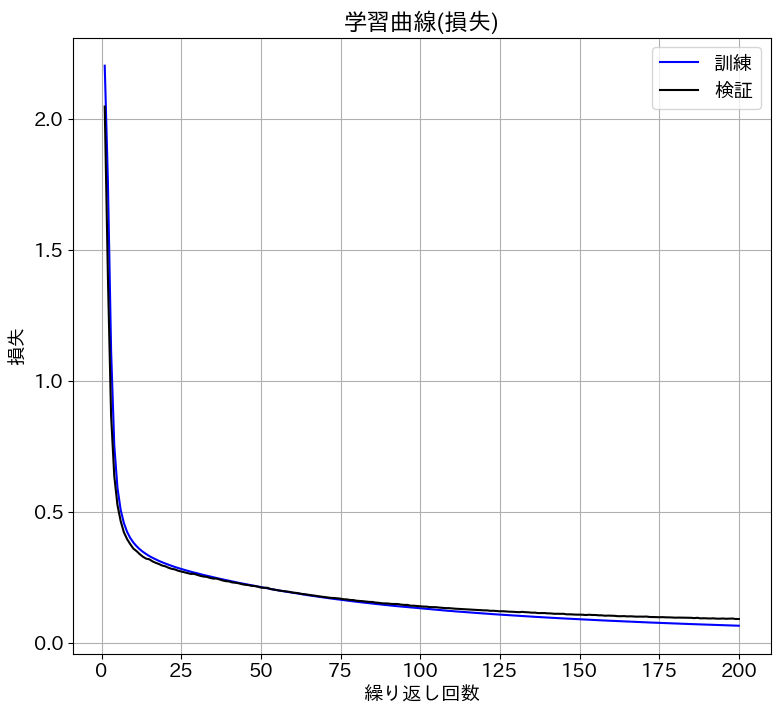

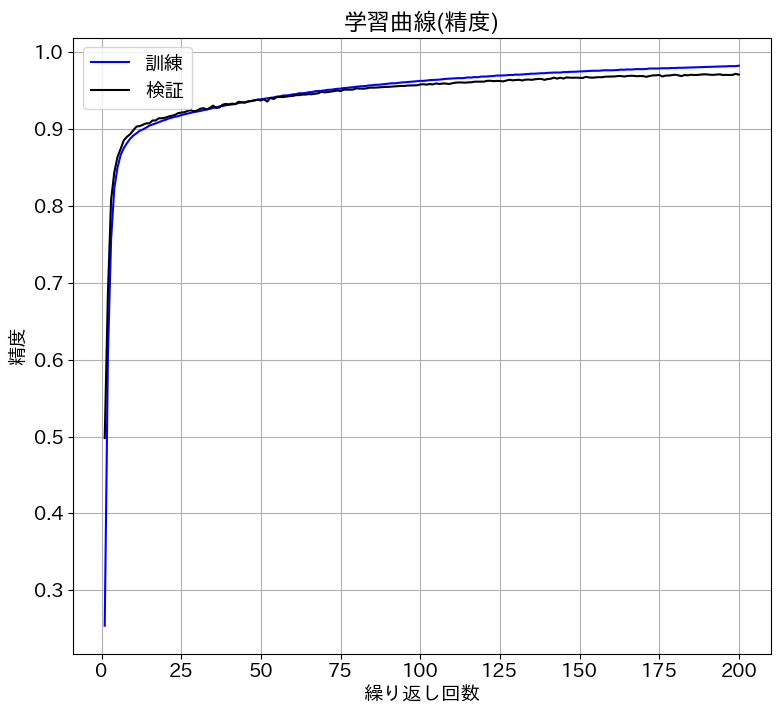

In [48]:
#損失と精度の確認

print(f'初期状態: 損失: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}' )
print(f'最終状態: 損失: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

# 学習曲線の表示 (損失)
plt.plot(history2[:,0], history2[:,1], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

# 学習曲線の表示 (精度)

plt.plot(history2[:,0], history2[:,2], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()